<a href="https://colab.research.google.com/github/mkbensalah/Change-Detection-in-Hyperspectral-Images/blob/master/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 KB 4.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import itertools
from random import shuffle
import h5py
import json
import tensorflow as tf

import numpy as np
import scipy
import scipy.io as sio # Scipy input and output
import scipy.ndimage
from skimage.transform import rotate
import spectral # Module for processing hyperspectral image data.
import matplotlib
%matplotlib inline

# scikit-learn imports
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

# keras imports
import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, ConvLSTM2D, TimeDistributed
from keras.optimizers import SGD
from keras.models import load_model
from keras import backend as K
from keras.utils import np_utils

In [ ]:
def  load_dataset(dataset):
    """load dataset parameters from config.json"""


    with open('/content/drive/MyDrive/Minor Project/Config/config.json') as f:
        config = json.loads(f.read())
        params = config[dataset]
        data_1 = sio.loadmat(params['img_path_1'])['Data2009']
        data_2 = sio.loadmat(params['img_path_2'])['Data2015']
        labels = sio.loadmat(params['gt_path'])['GT_end']


    return data_1, data_2, labels

In [ ]:
data_1, data_2 , labels= load_dataset("Indian_pines")



In [ ]:
def apply_pca(X, num_components=75):
    """apply pca to X and return new_X"""

    new_X = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=num_components, whiten=True)
    new_X = pca.fit_transform(new_X)
    new_X = np.reshape(new_X, (X.shape[0],X.shape[1], num_components))
    return new_X, pca

In [ ]:
def pad_with_zeros(X, margin=2):
    """apply zero padding to X with margin"""

    new_X = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    new_X[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return new_X

In [ ]:
def create_patches(X, y, window_size=7, remove_zero_labels = True):
    """create patch from image. suppose the image has the shape (w,h,c) then the patch shape is
    (w*h,window_size,window_size,c)"""

    margin = int((window_size - 1) / 2)
    zero_padded_X = pad_with_zeros(X, margin=margin)
    # split patches
    patches_data = np.zeros((X.shape[0] * X.shape[1], window_size, window_size, X.shape[2]))
    patchs_labels = np.zeros((X.shape[0] * X.shape[1]))
    patch_index = 0
    for r in range(margin, zero_padded_X.shape[0] - margin):
        for c in range(margin, zero_padded_X.shape[1] - margin):
            patch = zero_padded_X[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patches_data[patch_index, :, :, :] = patch
            patchs_labels[patch_index] = y[r-margin, c-margin] + 1
            patch_index = patch_index + 1

    if remove_zero_labels:
        patches_data = patches_data[patchs_labels>0,:,:,:]
        patchs_labels = patchs_labels[patchs_labels>0]
        patchs_labels -= 1
    return patches_data, patchs_labels

In [ ]:
def split_train_test_set(X, y, test_ratio=0.10):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=345,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
def oversample_weak_classes(X, y):
    """"balance the dataset by prforming oversample of weak classes (making each class have close labels_counts)"""
    unique_labels, labels_counts = np.unique(y, return_counts=True)

    print(unique_labels.shape)
    print(unique_labels)
    print(labels_counts.shape)
    print(labels_counts)
    max_count = np.max(labels_counts)
    labels_inverse_ratios = max_count / labels_counts
    #print(labels_inverse_ratios)
    # repeat for every label and concat
    print(labels_inverse_ratios)
    new_X = X[y == unique_labels[0], :, :, :].repeat(round(labels_inverse_ratios[0]), axis=0)
    new_Y = y[y == unique_labels[0]].repeat(round(labels_inverse_ratios[0]), axis=0)
    for label, labelInverseRatio in zip(unique_labels[1:], labels_inverse_ratios[1:]):
        cX = X[y== label,:,:,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        new_X = np.concatenate((new_X, cX))
        new_Y = np.concatenate((new_Y, cY))
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(new_Y.shape[0])
    new_X = new_X[rand_perm, :, :, :]
    new_Y = new_Y[rand_perm]
    unique_labels, labels_counts = np.unique(new_Y, return_counts=True)

#     print(unique_labels.shape)
#     print(unique_labels)
#     print(labels_counts.shape)
#     print(labels_counts)
    return new_X, new_Y

In [ ]:
def augment_data(X_train):
    """augment the data by taking each patch and randomly performing
    a flip(up/down or right/left) or a rotation"""

    for i in range(int(X_train.shape[0]/2)):
        patch = X_train[i,:,:,:]
        num = random.randint(0,2)
        if (num == 0):

            flipped_patch = np.flipud(patch)
        if (num == 1):

            flipped_patch = np.fliplr(patch)
        if (num == 2):

            no = random.randrange(-180,180,30)
            flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0),
                                                               reshape=False, output=None, order=3, mode='constant', cval=0.0, prefilter=False)


        patch2 = flipped_patch
        X_train[i,:,:,:] = patch2

    return X_train

In [ ]:
#Parameters
dataset = "Indian_pines" # Indian_pines or PaviaU or or Salinas  . check config.json
window_size = 7
num_pca_components = 30
test_ratio = 0.25

In [ ]:
X_1, X_2, y = load_dataset(dataset)

X_1,pca = apply_pca(X_1,num_pca_components)
X_1_patches, y_patches = create_patches(X_1, y, window_size=window_size)
X_1_train, X_1_test, y_1_train, y_test = split_train_test_set(X_1_patches, y_patches, test_ratio)
X_1_train, y_1_train = oversample_weak_classes(X_1_train, y_1_train)
X_1_train = augment_data(X_1_train)

X_2,pca = apply_pca(X_2,num_pca_components)
X_2_patches, y_patches = create_patches(X_2, y, window_size=window_size)
X_2_train, X_2_test, y_train, y_test = split_train_test_set(X_2_patches, y_patches, test_ratio)
X_2_train, y_train = oversample_weak_classes(X_2_train, y_train)
X_2_train = augment_data(X_2_train)







y_train = np_utils.to_categorical(y_train) # convert class labels to on-hot encoding
y_test = np_utils.to_categorical(y_test)
y_train = y_train[:,-1]
print(X_1_train.shape)
print(X_1_train.ndim)
print(X_2_train.shape)
print(X_2_train.ndim)
print(y_test.shape)
print(y_1_train.shape)

(2,)
[0. 1.]
(2,)
[27424  2576]
[ 1.         10.64596273]


<ipython-input-12-966bd6f111d9>:17: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0),


(2,)
[0. 1.]
(2,)
[27424  2576]
[ 1.         10.64596273]


<ipython-input-12-966bd6f111d9>:17: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0),


(55760, 7, 7, 30)
4
(55760, 7, 7, 30)
4
(10000, 2)
(55760,)


In [ ]:
data = np.zeros(shape=(55760,2,7,7,30))
labels = np.zeros(shape=(55760,1))
labels = y_train
data_1 = np.array([X_1_train[0], X_2_train[0]])
data[0] = data_1
for i in range(1, 55760):
  x = np.array([X_1_train[i], X_2_train[i]])

  data[i] = x
print(data.shape)
print(data.ndim)

print(y_train.shape)
print(y_train.ndim)


(55760, 2, 7, 7, 30)
5
(55760,)
1


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D,Conv3D, MaxPooling2D, MaxPooling3D,UpSampling2D, Concatenate, Reshape, GlobalAveragePooling3D, Dense, Add, TimeDistributed, Flatten, LSTM, Permute, multiply, Activation, Conv3DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import UpSampling3D
from keras.layers import UpSampling2D, Lambda
from tensorflow.keras import backend as K
from keras.layers import Conv2D, Conv3D, Activation, Multiply, Add
from keras.layers import *
from keras.activations import softmax


def attention_block(input_tensor, gating_tensor, inter_shape):
    # Project gating tensor to same number of channels as input tensor
    gating_tensor = Conv2D(inter_shape, (1, 1), padding='same')(gating_tensor)
    gating_tensor = BatchNormalization()(gating_tensor)
    gating_tensor = Activation('relu')(gating_tensor)

    # Compute intermediate tensor
    x = Concatenate(axis=-1)([input_tensor, gating_tensor])
    x = TimeDistributed(Conv2D(inter_shape, (1, 1), padding='same', activation='relu'))(x)
    x = TimeDistributed(Conv2D(1, (1, 1), padding='same', activation='sigmoid'))(x)

    # Compute the attended input tensor
    input_tensor_attended = Multiply()([input_tensor, x])
    return input_tensor_attended



def residual_block(input_tensor, filters, kernel_size=3):
    # Residual block consisting of two 2D convolutional layers and an element-wise addition operation
    x = Conv2D(filters, kernel_size, padding='same', activation='relu')(input_tensor)
    x = Conv2D(filters, kernel_size, padding='same', activation=None)(x)
    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x





def define_model(num_pca_components=10):
    # Define input shape
    input_shape = (2, 7, 7, 30)  # (batch_size, sequence_length, height, width, channels)
    C1 = 3 * num_pca_components  # Number of filters in the first convolutional layer

    # Define input tensor
    input_tensor = Input(shape=input_shape)

    # Encoder
    # Apply two convolutional layers with C1 filters, followed by a residual block and max pooling
    x1 = TimeDistributed(Conv2D(C1, (3, 3), padding='same', activation='relu'))(input_tensor)
    x1 = TimeDistributed(Conv2D(C1, (3, 3), padding='same', activation=None))(x1)
    shortcut1 = x1
    x2 = residual_block(x1, C1)
    x2 = residual_block(x2, C1)
    x2 = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x2)

    # Apply two convolutional layers with 2*C1 filters, followed by a residual block, shortcut connection, and max pooling
    x3 = TimeDistributed(Conv2D(2 * C1, (3, 3), padding='same', activation='relu'))(x2)
    shortcut2 = x3
    x3 = residual_block(x3, 2 * C1)
    x3 = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x3)
    # Apply two convolutional layers with 4*C1 filters, followed by a residual block, shortcut connection, and max pooling
    x4 = TimeDistributed(Conv2D(4 * C1, (3, 3), padding='same', activation='relu'))(x3)
    shortcut3 = x4
    x4 = residual_block(x4, 4 * C1)
    x4 = residual_block(x4, 4 * C1)
    x4 = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x4)

    # Apply two convolutional layers with 8*C1 filters, followed by a residual block and up-sampling
    x5 = TimeDistributed(Conv2D(8 * C1, (3, 3), padding='same', activation='relu'))(x4)
    x5 = residual_block(x5, 8 * C1)
    x5 = residual_block(x5, 8 * C1)
    x5 = TimeDistributed(UpSampling2D((2, 2)))(x5)

    # Decoder
    # Apply two convolutional layers with 4*C1 filters, followed by an attention block, residual block, shortcut connection, and up-sampling
    x6 = Concatenate()([shortcut3, x5])
    x6 = TimeDistributed(Conv2D(4 * C1, (3, 3), padding='same', activation='relu'))(x6)
    x6 = attention_block(x6, shortcut3, 2 * C1)
    x6 = residual_block(x6, 4 * C1)
    x6 = TimeDistributed(UpSampling2D((2, 2)))(x6)


    # Apply two convolutional layers with 2*C1 filters, followed by an attention block, residual block, shortcut connection, and up-sampling
    x7 = Concatenate()([shortcut2, x6])
    x7 = TimeDistributed(Conv2D(2 * C1, (3, 3), padding='same', activation='relu'))(x7)
    x7 = attention_block(x7, shortcut2, C1)
    x7 = residual_block(x7, 2 * C1)
    x7 = TimeDistributed(UpSampling2D((2,2)))(x7)

    # Apply two convolutional layers with C1 filters, followed by an attention block, residual block, and final convolutional layer
    #shortcut1 = TimeDistributed(UpSampling2D(size=(2,2)))(shortcut1)
    shortcut1 = ZeroPadding3D(padding=((0,0), (0,1), (0,1)))(shortcut1)
    x8 = Concatenate()([shortcut1, x7])
    x8 = TimeDistributed(Conv2D(C1, (3, 3), padding='same', activation='relu'))(x8)
    x8 = attention_block(x8, shortcut1, C1)
    x8 = residual_block(x8, C1)
    x8 = TimeDistributed(Conv2D(1, (1, 1), activation='sigmoid'))(x8)

    # Flatten output and pass through LSTM layer
    x9 = TimeDistributed(Flatten())(x8)
    x9 = LSTM(128)(x9)

    # Fully connected layers
    x10 = Dense(1024, activation='relu')(x9)
    x10 = Dense(512, activation='relu')(x10)
    out = Dense(1, activation='sigmoid')(x10)

    # Define the model input, output, and compile the model
    model = Model(inputs=input_tensor, outputs=out)

    # Compile model with binary cross-entropy loss and Adam optimizer
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=binary_crossentropy,metrics=['accuracy'])

    return model



In [ ]:
print(num_pca_components)
model = define_model()
model.summary()

30
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2, 7, 7, 30  0           []                               
                                )]                                                                
                                                                                                  
 time_distributed_22 (TimeDistr  (None, 2, 7, 7, 30)  8130       ['input_2[0][0]']                
 ibuted)                                                                                          
                                                                                                  
 time_distributed_23 (TimeDistr  (None, 2, 7, 7, 30)  8130       ['time_distributed_22[0][0]']    
 ibuted)                                                                                 

In [ ]:
print( X_1_train[0].shape )

(7, 7, 30)


In [ ]:
model.fit(data, labels, batch_size=32, epochs=5)

Epoch 1/5
1743/1743 [==============================] - 1247s 708ms/step - loss: 0.1379 - accuracy: 0.9537
Epoch 2/5
1743/1743 [==============================] - 1186s 680ms/step - loss: 0.0631 - accuracy: 0.9808
Epoch 3/5
1743/1743 [==============================] - 1193s 684ms/step - loss: 0.0422 - accuracy: 0.9871
Epoch 4/5
1743/1743 [==============================] - 1198s 688ms/step - loss: 0.0315 - accuracy: 0.9899
Epoch 5/5
1743/1743 [==============================] - 1185s 680ms/step - loss: 0.0224 - accuracy: 0.9923


In [ ]:
model.save('/content/drive/MyDrive/Minor Project/Att_Unet.h5')

In [ ]:
# We have already trained the model
data_1 = np.array([X_1_train[0], X_1_train[1]])

data_2= np.array([X_1_train[2], X_1_train[3]])

data = np.array([data_1, data_2])

print(data.shape)
print(data.ndim)
labels =np.array([y_train[0], y_train[1]])
print(labels.shape)
print(labels.ndim)


(2, 2, 7, 7, 30)
5
(2,)
1


In [ ]:
print(model.layers[2])

In [ ]:
X_1, X_2,y = load_dataset("Indian_pines")
X_1,pca = apply_pca(X_1,num_pca_components)
X_2,pca = apply_pca(X_2,num_pca_components)
height = y.shape[0]
width = y.shape[1]
patch_size = window_size
data = np.zeros(shape=(55760,2,7,7,30))
data_1 = np.array([X_1, X_2])
X = X_1
print(X_1.shape)

print(x.ndim)


(200, 200, 30)
4


In [ ]:
def get_patch(data,height_index,width_index):
    #transpose_array = data.transpose((2,0,1))
    #print transpose_array.shape
    height_slice = slice(height_index, height_index+patch_size)
    width_slice = slice(width_index, width_index+patch_size)
    patch = data[height_slice, width_slice, :]

    return patch

In [ ]:
def generate_pridected_image():
    """generate the predicted image"""
    outputs = np.zeros((height,width))

    for i in range(height-patch_size+1):
        for j in range(width-patch_size+1):
            target = y[int(i+patch_size/2), int(j+patch_size/2)]
            if target == 0 :
                continue
            else :
                image_patch=get_patch(X,i,j)
                X_test_image = image_patch.reshape(7,7,30).astype('float32')
                image_patch=get_patch(X_2,i,j)
                X_2_test_image = image_patch.reshape(7,7,30).astype('float32')

                X_F = np.array([X_test_image, X_2_test_image])
                X_2_F = X_F.reshape(1,X_F.shape[0],X_F.shape[1],X_F.shape[2],X_F.shape[3])

                prediction = ((model.predict(X_2_F) > 0.5).astype("int32"))
                outputs[int(i+patch_size/2)][int(j+patch_size/2)] = prediction+1
    return outputs.astype(int)

In [ ]:
outputs=generate_pridected_image()


1/1 [==============================] - 0s 30ms/step


KeyboardInterrupt: ignored

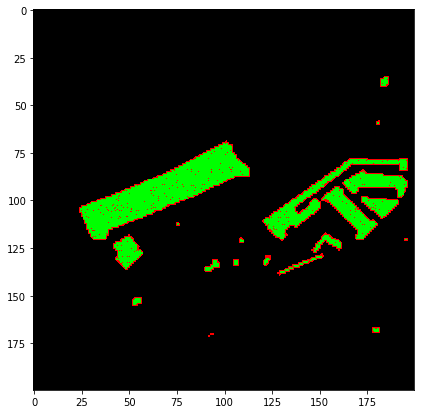

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

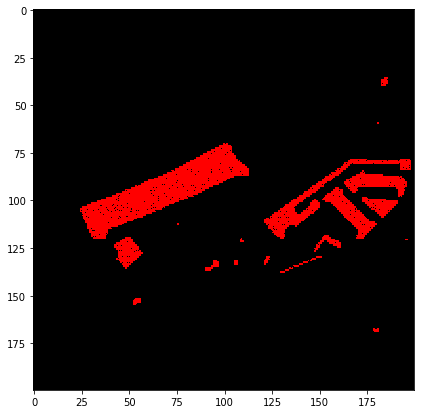

In [ ]:
gt_image = spectral.imshow(classes = y,figsize =(7,7))

In [ ]:

loss, accuracy = evaluate_model(model, data2, y_2_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")


Test set loss: 0.0443
Test set accuracy: 0.9861
Test loss: 0.044325947761535645
Test accuracy: 0.9861000180244446


In [ ]:
X_1, X_2, y = load_dataset(dataset)

X_1,pca = apply_pca(X_1,num_pca_components)
X_1_patches, y_patches = create_patches(X_1, y, window_size=window_size)
X_1_train, X_1_test, y_1_train, y_1_test = split_train_test_set(X_1_patches, y_patches, test_ratio)
X_1_train, y_1_train = oversample_weak_classes(X_1_train, y_1_train)
X_1_train = augment_data(X_1_train)

X_2,pca = apply_pca(X_2,num_pca_components)
X_2_patches, y_patches = create_patches(X_2, y, window_size=window_size)
X_2_train, X_2_test, y_train, y_2_test = split_train_test_set(X_2_patches, y_patches, test_ratio)
X_2_train, y_train = oversample_weak_classes(X_2_train, y_train)
X_2_train = augment_data(X_2_train)







y_train = np_utils.to_categorical(y_train) # convert class labels to on-hot encoding
y_2_test = np_utils.to_categorical(y_2_test)
y_train = y_train[:,-1]
y_2_test = y_2_test[:,-1]
print(X_1_train.shape)
print(X_1_train.ndim)
print(X_2_train.shape)
print(X_2_train.ndim)
print(y_1_test.shape)
print(y_1_train.shape)

(2,)
[0. 1.]
(2,)
[27424  2576]
[ 1.         10.64596273]


<ipython-input-12-966bd6f111d9>:17: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0),


(2,)
[0. 1.]
(2,)
[27424  2576]
[ 1.         10.64596273]


<ipython-input-12-966bd6f111d9>:17: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0),


(55760, 7, 7, 30)
4
(55760, 7, 7, 30)
4
(10000,)
(55760,)


In [ ]:
print(X_2_test.shape)

(10000, 7, 7, 30)


In [ ]:
data2 = np.zeros(shape=(10000,2,7,7,30))
labels = np.zeros(shape=(10000,1))
labels2 = np.array([y_1_test[0], y_2_test[0]])
data_12 = np.array([X_1_test[0], X_2_test[0]])
data2[0] = data_12
for i in range(1, 10000):
  x = np.array([X_1_test[i], X_2_test[i]])

  data2[i] = x


print(data2.shape)
print(X_2_test.shape)



(10000, 2, 7, 7, 30)
(10000, 7, 7, 30)


In [ ]:
def evaluate_model(model, X_test, y_test):
    """Evaluate the model on the test set"""
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print("Test set loss: {:.4f}".format(loss))
    print("Test set accuracy: {:.4f}".format(accuracy))
    return loss, accuracy
